In [1]:
# OBJECTIVE BUILD HISTOGRAM AND STATISTiCS FOR PROCESSES BY ENDPOINTS
import numpy as np
import pandas as pd
import util
import matplotlib.pyplot as plt

df = pd.read_csv('Without incomplete cases-BPI Challenge 2017 2.csv', delimiter=';', encoding='utf-8-sig')

keepcolumns  =  ['Case ID','Activity','Start Timestamp']

origactivity  = ['A_Pending','A_Cancelled','A_Denied']
aliasactivity = ['Pending','Cancelled','Denied']

#filter first then alias it
filtervalues  = origactivity + ['A_Create Application']




In [2]:
#Data wraggling 1
# 1.A - filter columns
df = df.loc[:,keepcolumns]

#1.B - filter start endpoints
filtermask = df['Activity'].isin(filtervalues)
df = df[filtermask]

#print df.shape[0] 62819 There seems to be 1 application with two starts / endpoints
print df.head()

                   Case ID              Activity          Start Timestamp
0    Application_652823628  A_Create Application  2016/01/01 07:51:15.304
18   Application_652823628             A_Pending  2016/01/14 13:49:11.420
19  Application_1691306052  A_Create Application  2016/01/01 08:16:11.500
31  Application_1691306052              A_Denied  2016/01/07 11:29:49.671
33   Application_428409768  A_Create Application  2016/01/01 09:19:38.177


In [3]:
#Data wraggling 2
# 2.A - start vs endpoint
filtermask = df['Activity'] == 'A_Create Application'
startdf    = df[filtermask]
endpointdf = df[~filtermask] 

# 2.B - rename columns on endpoints before merge
endpointdf.columns = ['Case ID','Endpoint','Endpoint Timestamp']
df = startdf.merge(endpointdf, on='Case ID')
df.drop('Activity', axis=1, inplace=True)

#2.C - Compute a new Delta column
startseries    = pd.to_datetime(df['Start Timestamp'])
endpointseries = pd.to_datetime(df['Endpoint Timestamp'])

df['Delta'] = ( endpointseries - startseries).astype('timedelta64[ns]')

#2.D - Rename endpoints
df.loc[:,'Endpoint'] = df['Endpoint'].str.replace('A_','')
print df.head()



                  Case ID          Start Timestamp   Endpoint  \
0   Application_652823628  2016/01/01 07:51:15.304    Pending   
1  Application_1691306052  2016/01/01 08:16:11.500     Denied   
2   Application_428409768  2016/01/01 09:19:38.177    Pending   
3  Application_1746793196  2016/01/01 10:34:53.911    Pending   
4   Application_828200680  2016/01/01 11:00:04.360  Cancelled   

        Endpoint Timestamp                   Delta  
0  2016/01/14 13:49:11.420 13 days 05:57:56.116000  
1  2016/01/07 11:29:49.671  6 days 03:13:38.171000  
2  2016/01/14 05:00:14.450 12 days 19:40:36.273000  
3  2016/01/28 10:18:51.292 26 days 23:43:57.381000  
4  2016/02/02 05:00:20.734 31 days 18:00:16.374000  


In [4]:
#Data wraggling 3 Oddities 
#3.A - Drop duplicates Case ID 'Application_1116429997'
print df.shape[0]
df.drop_duplicates(subset=['Case ID'],keep='first', inplace=True)
print df.shape[0]

#3.B - No application must be faster then a day? False :/
mask = df['Delta'] < pd.Timedelta('1 Hour')
print df.loc[mask].head()



31410
31409
                     Case ID          Start Timestamp   Endpoint  \
829    Application_224758141  2016/01/12 17:52:12.845  Cancelled   
2597   Application_992706633  2016/02/04 16:08:36.049  Cancelled   
2813   Application_772295828  2016/02/08 06:41:21.886  Cancelled   
3152  Application_1162167865  2016/02/11 14:27:08.124  Cancelled   
3409   Application_522241789  2016/02/15 13:43:04.177  Cancelled   

           Endpoint Timestamp           Delta  
829   2016/01/12 18:02:38.034 00:10:25.189000  
2597  2016/02/04 16:53:44.558 00:45:08.509000  
2813  2016/02/08 06:58:56.385 00:17:34.499000  
3152  2016/02/11 14:35:45.827 00:08:37.703000  
3409  2016/02/15 13:46:39.915 00:03:35.738000  


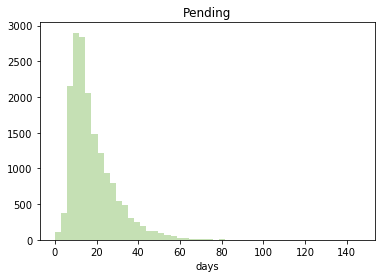

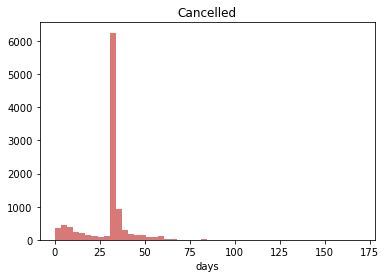

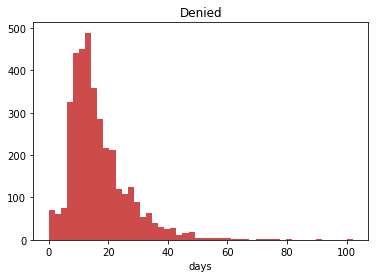

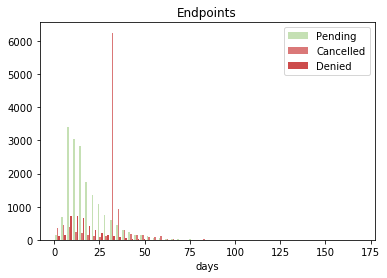

In [5]:
#3 PLOT
rgb = {'Pending': '#c5e0b4','Cancelled': '#da7878','Denied': '#cd4b4b'}
X = []
C = []
for acty in aliasactivity:
    # Histogram of success per minute
    actydf = df[df['Endpoint'] == acty]
    x =  pd.to_timedelta(actydf['Delta']) / np.timedelta64(1, 's')
    x =  util.seconds2hours(x)
    x =  x / 24

    X.append(x)
    C.append(rgb[acty])     
    plt.title(acty)
    plt.xlabel('days')
    plt.hist(x, bins=50, color=rgb[acty])
    plt.savefig("throughput_analysis_1_" + acty.lower() + ".eps", format='eps', dpi=1000)
    plt.show()


plt.title('Endpoints')
plt.xlabel('days')
plt.hist(X, bins=50, color=C)
plt.legend( tuple(aliasactivity) )
plt.savefig("throughput_analysis_1_endpoints.eps", format='eps', dpi=1000)
plt.show()    

In [6]:
#4 Summarize

pivotdf = df
pivotdf['Delta'] = pivotdf['Delta'].dt.total_seconds() / (24*3600)

tables = []
tables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=len)     )
tables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.sum)  )
tables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.mean) )
tables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.std)  )
tables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.min )  )
tables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.median ))
tables.append(  pd.pivot_table(pivotdf, values=['Delta'], columns=['Endpoint'], aggfunc=np.max) )


tabledf = pd.concat(tables, axis=0)
tabledf['Endpoint'] = ['Total Applications', 'Total Days', 'Average', 'Std', 'Min', 'Median', 'Max']
tabledf = tabledf.loc[:,['Endpoint','Pending','Denied','Cancelled']]
print tabledf

tabledf.to_csv('throughput_analysis_1_by_endpoints.csv')



Endpoint            Endpoint        Pending        Denied      Cancelled
Delta     Total Applications   17227.000000   3752.000000   10430.000000
Delta             Total Days  312018.067288  62802.383010  311440.349099
Delta                Average      18.112153     16.738375      29.860053
Delta                    Std      11.478906     10.026359      12.352909
Delta                    Min       0.005201      0.002327       0.002497
Delta                 Median      14.822164     14.095599      31.616007
Delta                    Max     145.954281    102.119337     169.114118
